In [7]:
import tensorflow as tf
import keras
from keras import backend as bk
import timeit

import sys
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

from scipy.integrate import ode
import math as mt
import numpy as np
import matplotlib.pyplot as plt
import random as rdm
import time
from datetime import datetime
import matplotlib.animation as animation
from IPython.display import display, clear_output


physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [8]:
##############################################################################################################
###################################### Linear Modules ########################################################
##############################################################################################################


class linear_module_up:
    
    def __init__(self):
        with tf.device('/GPU:1'):
            self.a11 = tf.Variable(rdm.choice([-1,1])*rdm.random()) #tf.constant(rdm.random()) 
    
    def run(self, X):
        with tf.device('/GPU:1'):
            L = tf.concat([[[1., self.a11]], [[0., 1.]]], 0)
        return tf.matmul(L, X)
    
    def Variables(self):
        return [self.a11]
    
    def grad_des(self, grad, rate):
        with tf.device('/GPU:1'):
            self.a11 = tf.Variable(self.a11 - rate*grad)

        
class linear_module_low:
    
    def __init__(self):
        with tf.device('/GPU:1'):
            self.a11 = tf.constant(rdm.choice([-1,1])*rdm.random()) #tf.Variable(rdm.random())
    
    def run(self, X):
        with tf.device('/GPU:1'):
            L = tf.concat([[[1., 0.]], [[self.a11, 1.]]], 0)
        return tf.matmul(L, X)
    
    def Variables(self):
        return [self.a11]
    
    def grad_des(self, grad, rate):
        with tf.device('/GPU:1'):
            self.a11 = tf.Variable(self.a11 - rate*grad)

##############################################################################################################
###################################### Activation Modules ####################################################
##############################################################################################################

class activation_module_up:
    
    def __init__(self):
        with tf.device('/GPU:1'):
            self.a1 = tf.constant(rdm.choice([-1,1])*rdm.random()) #tf.Variable(rdm.random())        
    
    def run(self, X):
        with tf.device('/GPU:1'):
            L = tf.reshape(tf.stack([X[0] + self.a1*tf.math.sigmoid(X[1]), X[1]]),(2,1))
        return  L

    
    def Variables(self):
        return [self.a1]
    
    def grad_des(self, grad, rate):
        with tf.device('/GPU:1'):
            self.a1 = tf.Variable(self.a1 - rate*grad)

        
class activation_module_low:
    
    def __init__(self):
        with tf.device('/GPU:1'):
            self.a1 = tf.constant(rdm.choice([-1,1])*rdm.random()) #tf.Variable(rdm.random())
        
    
    def run(self, X):
        with tf.device('/GPU:1'):
            L = tf.reshape(tf.stack([X[0], X[1] + self.a1*tf.math.sigmoid(X[0])]),(2,1))
        return L

    
    def Variables(self):
        return [self.a1]
    
    def grad_des(self, grad, rate):
        with tf.device('/GPU:1'):
            self.a1 = tf.Variable(self.a1 - rate*grad)

        


In [9]:
class SympNet:

    def __init__(self):
        
        self.L1 = linear_module_up()
        self.L2 = linear_module_low()
        
        self.A1 = activation_module_up()
        
        self.L3 = linear_module_up()
        self.L4 = linear_module_low()
        
        self.A2 = activation_module_low()

        self.L5 = linear_module_up()
        self.Lout = linear_module_low()


    def run(self, X):
        
        boom = self.L1.run(X)
        boom1 = self.L2.run(boom)
        
        boom2 = self.A1.run(boom1)
        
        boom3 = self.L3.run(boom2)
        boom4 = self.L4.run(boom3)
        
        boom5 = self.A2.run(boom4)
        
        boom6 = self.L5.run(boom5)
        boom7 = self.Lout.run(boom6)

        return boom7
    
    
    ##################################### Loss function ##########################
    
    def get_loss(self, X, X_target):
        with tf.device('/GPU:1'):
            
            loss = 0
            for i,j in zip(X,X_target):
                loss = loss + tf.norm(self.run(i) - j)**2
                    
        return loss/(len(X)*2)

    
    ################################### get gradient ############################
    
    def get_grad(self, X, X_target):
        with tf.device('/GPU:1'):
        
            with tf.GradientTape() as tape:

                tape.watch(self.L1.Variables())
                tape.watch(self.L2.Variables())

                tape.watch(self.A1.Variables())


                tape.watch(self.L3.Variables())
                tape.watch(self.L4.Variables())

                tape.watch(self.A2.Variables())

                tape.watch(self.L5.Variables())
                tape.watch(self.Lout.Variables())

                L = self.get_loss(X, X_target)

                g = tape.gradient(L, [self.L1.Variables(), self.L2.Variables(), self.A1.Variables(), self.L3.Variables(), self.L4.Variables(), self.A2.Variables(), self.L5.Variables(), self.Lout.Variables()])

        return [item for sublist in g for item in sublist]

    ################################## perform gradient descent ##################
    
    def network_learn(self, X, X_target, rate):
        
        g = self.get_grad( X, X_target)
                
        self.L1.grad_des(g[0], rate)
        self.L2.grad_des(g[1], rate)
        
        self.A1.grad_des(g[2], rate)
        
        self.L3.grad_des(g[3], rate)
        self.L4.grad_des(g[4], rate)
        
        self.A2.grad_des(g[5], rate)

        self.L5.grad_des(g[6], rate)
        self.Lout.grad_des(g[7], rate)


### Training Dataset

In [10]:
def leapfrog(q0, p0, Δt, N):
    q = [q0]
    p = [p0]
    p̄ = []
    for i in range(N):
        p̄.append(p[-1] - 0.5*Δt*mt.sin(q[-1]))
        q.append(q[-1] + Δt*p̄[-1])
        p.append(p̄[-1] - 0.5*Δt*mt.sin(q[-1]))
    
    X = []
    for i,j in zip(p,q):
        X.append(tf.constant([[i],[j]]))
    return X[0:len(X)-1], X[1:]

def plot_true_tr(leapfrog, q0, p0, Δt, N):
    X = leapfrog(q0, p0, Δt, N)[0]
    q = []
    p = []
    for i in range(len(X)):
        q.append(X[i][0].numpy()[0])
        p.append(X[i][1].numpy()[0])
    plt.plot(p, q)

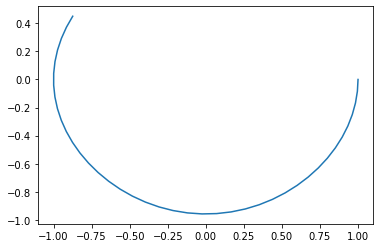

In [12]:
q0 = 1.
p0 = 0.
Δt = 0.1
N = 40

X = leapfrog(q0, p0, Δt, N)
plot_true_tr(leapfrog, q0, p0, Δt, N)


In [13]:
Model = SympNet()
#Model1 = Model

tf.debugging.set_log_device_placement(True)

print(Model.get_loss(X[0], X[1]))

losses = []

start_time = time.time()

for i in range(200):
    if i%10==0:
        print(Model.get_loss(X[0], X[1]))
    Model.network_learn(X[0], X[1], 0.001)
    losses.append(Model.get_loss(X[0],X[1]))

print("running time : %s seconds" % (time.time() - start_time))

print(Model.get_loss(X[0], X[1]))

tf.Tensor(1.1613317, shape=(), dtype=float32)
tf.Tensor(1.1613317, shape=(), dtype=float32)
tf.Tensor(1.0672879, shape=(), dtype=float32)
tf.Tensor(0.9871168, shape=(), dtype=float32)
tf.Tensor(0.9177972, shape=(), dtype=float32)
tf.Tensor(0.8571291, shape=(), dtype=float32)
tf.Tensor(0.8034746, shape=(), dtype=float32)
tf.Tensor(0.7555907, shape=(), dtype=float32)
tf.Tensor(0.71251905, shape=(), dtype=float32)
tf.Tensor(0.67350835, shape=(), dtype=float32)
tf.Tensor(0.63796145, shape=(), dtype=float32)
tf.Tensor(0.60539836, shape=(), dtype=float32)
tf.Tensor(0.5754283, shape=(), dtype=float32)
tf.Tensor(0.5477306, shape=(), dtype=float32)
tf.Tensor(0.5220386, shape=(), dtype=float32)
tf.Tensor(0.4981286, shape=(), dtype=float32)
tf.Tensor(0.47581205, shape=(), dtype=float32)
tf.Tensor(0.45492846, shape=(), dtype=float32)
tf.Tensor(0.43533984, shape=(), dtype=float32)
tf.Tensor(0.41692716, shape=(), dtype=float32)
tf.Tensor(0.39958727, shape=(), dtype=float32)
running time : 82.8973431

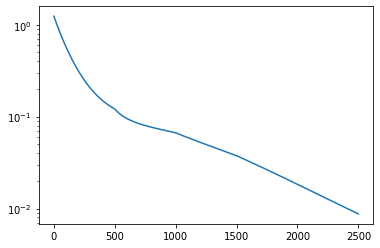

In [22]:
plt.plot(losses)
plt.yscale("log")
plt.show()

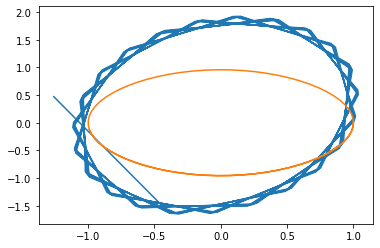

In [16]:
p = [Model.run(X[0][0])[0]]
q = [Model.run(X[0][0])[1]]
run = [Model.run(X[0][0])]

for i in range(100):
    run.append(Model.run(run[-1]))
    q.append(run[-1][0])
    p.append(run[-1][1])
    
    

#Model2.run(Model2.run(Model2.run(Model2.run(Model2.run(Model2.run(Model2.run(Model2.run(Model2.run(Model2.run(Model2.run(Model2.run(Model2.run(Model2.run(Model2.run(Model2.run(Model2.run(Model2.run(Model2.run(Model2.run(Model2.run(Model2.run(Model2.run(Model2.run(Model2.run(Model2.run(Model2.run(Model2.run(Model2.run(Model2.run(Model2.run(X[0][0])))))))))))))))))))))))))))))))
plt.plot(p, q)
plot_true_tr(leapfrog, q0, p0, Δt, 100)
plt.show()